In [1]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import ElectraForSequenceClassification, BertTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [2]:
from transformers import PreTrainedTokenizerFast
MODEL_NAME= "skt/kogpt2-base-v2"
tokenizer = PreTrainedTokenizerFast.from_pretrained(MODEL_NAME,
                                                    bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                                    pad_token='<pad>', mask_token='<mask>') 
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [3]:
tokenizer

PreTrainedTokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='left', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>', 'mask_token': '<mask>'})

# Load Koco Dataset

In [4]:
import pandas as pd
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
koco_train_df = pd.read_csv(data_path+"koco_hate_train.txt", sep="\t")
koco_test_df = pd.read_csv(data_path+"koco_hate_test.txt", sep="\t")
koco_train_df.head(5)

,comments,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",2
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2


In [5]:
tokenized_train_sentences = tokenizer(
                            list(koco_train_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

tokenized_test_sentences = tokenizer(
                            list(koco_test_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [7]:
train_label = koco_train_df["hate"].values
test_label =  koco_test_df["hate"].values

train_dataset = MyDataset(tokenized_train_sentences, train_label)
test_dataset = MyDataset(tokenized_test_sentences, test_label)

# 모델 튜닝

In [8]:
from coral_pytorch.layers import CoralLayer
from coral_pytorch.losses import CoralLoss, corn_loss
from torch.nn import CrossEntropyLoss
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.dataset import proba_to_label
from typing import Optional, Union, Tuple
from transformers.activations import get_activation

In [9]:
from transformers.modeling_outputs import SequenceClassifierOutput, SequenceClassifierOutputWithPast
from transformers import GPT2ForSequenceClassification

In [19]:
from transformers import GPT2PreTrainedModel, GPT2Model
import torch.nn as nn
class GPT2ForSequenceClassification(GPT2PreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"h\.\d+\.attn\.masked_bias", r"lm_head.weight"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.transformer = GPT2Model(config)
        self.score = nn.Linear(config.n_embd, self.num_labels, bias=False)
        self.coral_layer = CoralLayer(config.n_embd, config.num_labels)
        #self.classifier = nn.Linear(config.hidden_size, config.num_labels-1)
        self.hidden_states = None
        self.logits = None
        self.pooled_logits = None

        # Model parallel
        self.model_parallel = False
        self.device_map = None

        
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutputWithPast]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        transformer_outputs = self.transformer(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = transformer_outputs[0]
        #logits = self.coral_layer(hidden_states)
        self.hidden_states = hidden_states
        logits = self.coral_layer(hidden_states)
        probas = torch.sigmoid(logits)

        if input_ids is not None:
            batch_size, sequence_length = input_ids.shape[:2]
        else:
            batch_size, sequence_length = inputs_embeds.shape[:2]

        assert (
            self.config.pad_token_id is not None or batch_size == 1
        ), "Cannot handle batch sizes > 1 if no padding token is defined."
        if self.config.pad_token_id is None:
            sequence_lengths = -1
        else:
            if input_ids is not None:
                sequence_lengths = torch.ne(input_ids, self.config.pad_token_id).sum(-1) - 1
            else:
                sequence_lengths = -1
                logger.warning(
                    f"{self.__class__.__name__} will not detect padding tokens in `inputs_embeds`. Results may be "
                    "unexpected if using padding tokens in conjunction with `inputs_embeds.`"
                )

        pooled_logits = logits[torch.arange(batch_size, device=logits.device), sequence_lengths] #probas
        #logits = self.coral_layer(pooled_logits)
        probas = torch.sigmoid(pooled_logits)
        probas = torch.cumprod(probas, dim=1)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(pooled_logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(pooled_logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(pooled_logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(pooled_logits, labels)
            elif self.config.problem_type == "CORAL":
                iw = torch.tensor([0.3, 0.7]).to(device)
                loss_fct = CoralLoss()
                levels = levels_from_labelbatch(labels.view(-1) , num_classes=3).to(device)
                loss = loss_fct(pooled_logits, levels, importance_weights=iw)
                    
        if not return_dict:
            output = (pooled_logits,) + transformer_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutputWithPast(
            loss=loss,
            logits=probas,
            past_key_values=transformer_outputs.past_key_values,
            hidden_states=transformer_outputs.hidden_states,
            attentions=transformer_outputs.attentions,
        )

In [20]:
device = torch.device("cuda:0")
model = GPT2ForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, problem_type='CORAL')
model.to(device)

loading configuration file https://huggingface.co/skt/kogpt2-base-v2/resolve/main/config.json from cache at C:\Users\USER/.cache\huggingface\transformers\13bb826cf24517d7849a701e02452715a67c5e560142be3d4735442b2a545809.6b384eec6effdd44287f67715cd55bd0dff2cf846d843b932b43ba7b632b8b1e
Model config GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
  "created_date": "2021-04-28",
  "embd_pdrop": 0.1,
  "eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_epsilon": 1e-05,
  "license": "CC-BY-NC-SA 4.0",
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=Fal

In [21]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/', # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size=4,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/logs/',# 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [22]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [23]:
from transformers import Trainer
#model_path = 'C:/Users/USER/Desktop/2022_master/KoBERT/KoELECTRA_outputs/output/pytorch_model.bin'
#model.load_state_dict(torch.load(model_path))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [24]:
trainer.train()

***** Running training *****
  Num examples = 7896
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19740
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss
500,0.652600
1000,0.570300
1500,0.530500
2000,0.517600
2500,0.455500
3000,0.465600
3500,0.470400
4000,0.431300
4500,0.372100
5000,0.389600


Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-500\pytorch_model.bin
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-1000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-1000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-1000\pytorch

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-6000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-6000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-6000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoGPT2_CORAL_outputs\output\checkpoint-5000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-6500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/outpu

Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-11000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoGPT2_CORAL_outputs\output\checkpoint-10000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-11500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-11500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-11500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoG

C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-16500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-16500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/checkpoint-16500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoGPT2_CORAL_outputs\output\checkpoint-15500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

TrainOutput(global_step=19740, training_loss=0.2982992019576021, metrics={'train_runtime': 1223.9314, 'train_samples_per_second': 64.513, 'train_steps_per_second': 16.128, 'total_flos': 2579045561487360.0, 'train_loss': 0.2982992019576021, 'epoch': 10.0})

In [25]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.209944248199463,
 'eval_accuracy': 0.33970276008492567,
 'eval_f1': 0.16904384574749076,
 'eval_precision': 0.11323425336164189,
 'eval_recall': 0.3333333333333333,
 'eval_runtime': 0.5645,
 'eval_samples_per_second': 834.378,
 'eval_steps_per_second': 26.573,
 'epoch': 10.0}

In [26]:
trainer.save_model()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoGPT2_CORAL_outputs/output/pytorch_model.bin


In [27]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
predictions.predictions

array([[4.78591573e-06, 7.75366230e-12],
       [4.92729664e-01, 1.21924363e-01],
       [9.99445140e-01, 9.97808635e-01],
       [4.62864608e-01, 1.04528770e-01],
       [4.41230357e-01, 9.30662006e-02],
       [9.99999881e-01, 9.99999642e-01],
       [5.10547443e-06, 8.82366489e-12],
       [3.97832127e-06, 5.35767307e-12],
       [3.54075074e-01, 5.54191433e-02],
       [2.37681307e-02, 1.94288805e-04],
       [3.83867025e-01, 6.68579936e-02],
       [4.49080050e-01, 9.71191972e-02],
       [2.39607725e-05, 1.94349689e-10],
       [4.95105565e-01, 1.23390727e-01],
       [4.55105186e-01, 1.00311428e-01],
       [6.85246632e-05, 1.58960356e-09],
       [4.67888057e-01, 1.07323997e-01],
       [9.99978662e-01, 9.99915719e-01],
       [4.65288699e-01, 1.05871193e-01],
       [2.71543191e-04, 2.49649812e-08],
       [2.66431871e-05, 2.40300890e-10],
       [1.01605186e-03, 3.49702788e-07],
       [5.31442821e-01, 1.47437155e-01],
       [3.18801649e-05, 3.44053230e-10],
       [6.620582

In [32]:
from scipy import special
import pandas as pd

def custom_proba_to_label(probas, first_threshold, second_threshold):
    predict_levels = pd.DataFrame(probas)
    class_O = predict_levels[0].apply(lambda x: x > first_threshold)
    class_H = predict_levels[1].apply(lambda x: x > second_threshold)
    labels_v3 = pd.concat([class_O, class_H], axis=1)
    labels_v3 = labels_v3.sum(axis=1)
    return labels_v3

In [33]:
predicts_threshold = custom_proba_to_label(predictions.predictions.tolist(), 0.5, 0.5)

              precision    recall  f1-score   support

           0       0.41      0.94      0.57       160
           1       0.36      0.04      0.08       189
           2       0.66      0.45      0.54       122

    accuracy                           0.45       471
   macro avg       0.48      0.48      0.40       471
weighted avg       0.46      0.45      0.36       471



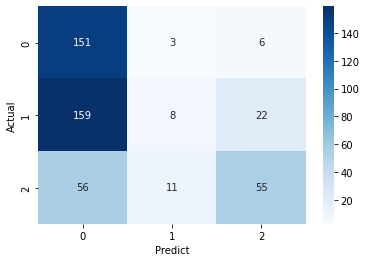

In [34]:
## classification_report
from coral_pytorch.dataset import corn_label_from_logits
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = predicts_threshold
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [35]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [36]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.6773)
tensor(0.9406)


In [49]:
from scipy import special
import pandas as pd

def custom_proba_to_label(probas, first_threshold, second_threshold):
    predict_levels = pd.DataFrame(probas)
    class_O = predict_levels[0].apply(lambda x: x > first_threshold)
    class_H = predict_levels[1].apply(lambda x: x > second_threshold)
    labels_v3 = pd.concat([class_O, class_H], axis=1)
    labels_v3 = labels_v3.sum(axis=1)
    return labels_v3

In [66]:
predicts_threshold = custom_proba_to_label(predictions.predictions.tolist(), 0.7, 0.3)

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       342
           1       0.20      0.02      0.03        62
           2       0.33      0.78      0.46        67

    accuracy                           0.69       471
   macro avg       0.47      0.53      0.45       471
weighted avg       0.72      0.69      0.68       471



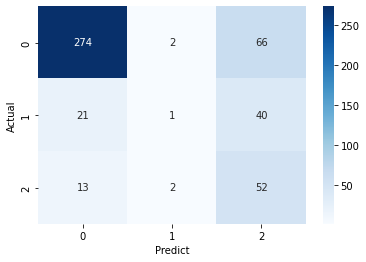

In [67]:
## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = predicts_threshold
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [68]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.4735)
tensor(0.8089)


In [74]:
predictions.label_ids

array([0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 2, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2,
       0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 2, 0,
       0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0,
       1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,

In [53]:
predictions

PredictionOutput(predictions=array([[9.95555747e-05, 3.75124291e-05],
       [1.90776882e-05, 7.18809815e-06],
       [4.26126033e-01, 2.18610957e-01],
       [1.54090267e-05, 5.80580036e-06],
       [4.43542629e-01, 2.30959401e-01],
       [4.85832632e-01, 2.62543648e-01],
       [5.36891021e-05, 2.02294377e-05],
       [5.09416386e-05, 1.91941908e-05],
       [1.41160726e-05, 5.31863770e-06],
       [7.37917617e-06, 2.78030598e-06],
       [4.76031780e-01, 2.55013168e-01],
       [6.24308495e-06, 2.35225093e-06],
       [1.23269429e-05, 4.64452569e-06],
       [4.51042235e-01, 2.36391559e-01],
       [4.45150799e-05, 1.67726739e-05],
       [6.73745490e-06, 2.53851863e-06],
       [4.78512853e-01, 2.56907135e-01],
       [2.71430588e-04, 1.02285703e-04],
       [5.93937980e-03, 2.24612933e-03],
       [4.83804179e-05, 1.82291060e-05],
       [1.14722243e-05, 4.32248407e-06],
       [1.10954734e-05, 4.18053560e-06],
       [9.99904394e-01, 9.99746144e-01],
       [2.32294424e-05, 8.75

In [78]:
item = [7.16244131e-02, 2.82472502e-02]
print([format(x, 'f') for x in item])

['0.071624', '0.028247']
